# C - Data Modeling

In this section, we will focus on various time-series modeling approaches to predict next month’s revenue based on historical data, utilizing RMSE as our error metric to ensure we assess error magnitude in the same units as the target.

To start, we will simplify our analysis by using data from all countries to identify the most effective model. Once the optimal approach is determined, we will develop tailored models for each country.

We will iteratively refine our models by adjusting data transformations, pipeline architectures, and hyperparameters to enhance performance. For the train-test split, we will retain the last 30 data points as our test set, while the remaining data will be utilized for training. After selecting the best model, we will re-train it on the entire dataset and prepare it for deployment.

## I - Loading the Data

### 1 - Importing the necessary librairies

In [1]:
## Import necessary libraries 

import pandas as pd
import numpy as np

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots  

import time
import warnings
warnings.filterwarnings('ignore')

print('\nNecessary librairies imported\n')


Necessary librairies imported



### 2 - Loading the dataframe

In [2]:
## loading the dataframe as loaded_df

from data_module import load_json_data

loaded_df_original = load_json_data('cs-train')

print("\nLoading Summary\n{}".format("-"*22))
print("\n... Dataframe loaded as 'loaded_df'\n")

## Information about the data types
print('\nThe columns are:',loaded_df_original.columns.tolist(), '\n')

# List of numerical columns
numerical_cols = loaded_df_original.select_dtypes(include='number').columns.tolist()

print(f'\nThe numerical columns in loaded_df are : {" and ".join(numerical_cols)}\n')

# List of categorycal columns
categorycal_cols = loaded_df_original.select_dtypes(include='category').columns.tolist()

print(f'\nThe categorycal columns in loaded_df are : {", ".join(categorycal_cols)}\n')

## Rows count
print(f'\nloaded_df contains initialy {len(loaded_df_original):,.0f} rows\n')



Loading Summary
----------------------

... Dataframe loaded as 'loaded_df'


The columns are: ['country', 'date', 'invoice_id', 'customer_id', 'stream_id', 'times_viewed', 'price', 'year', 'month', 'day'] 


The numerical columns in loaded_df are : times_viewed and price and year and month and day


The categorycal columns in loaded_df are : country, invoice_id, customer_id, stream_id


loaded_df contains initialy 815,011 rows



### 3 - Cleaning the dataframe

In [3]:
from cleaning_module import data_cleaning_pipeline

loaded_df = data_cleaning_pipeline(loaded_df_original)


Starting data cleaning pipeline...


Duplicate rows Summary
----------------------

The total number of rows before dropping duplicates is 815,011

... Removed 28,844 duplicate rows.

The total number of rows after dropping duplicates is 786,167


The numerical columns are : times_viewed and price and year and month and day

The total number of rows before dropping any invalid data is 786,167.


Data Quality Summary
--------------------------

The total number of invalid data points in times_viewed is 7,714

The total number of invalid data points in price is 5,252

The total number of invalid data points in year is 0

The total number of invalid data points in month is 0

The total number of invalid data points in day is 0

... Removed 12,328 rows with invalid data.

The total number of rows after dropping all invalid data is 773,839.


The numerical columns are : times_viewed and price and year and month and day


There are 20,965 rows identified with outliers in times_viewed data



### 4 - Creating a Time Series dataframe

In [4]:
from data_module import time_series_df

ts_df = time_series_df(loaded_df, country=None)
ts_df = ts_df[['date','revenue', 'purchases', 'total_views']]

# Ensure date dat type as datetime
ts_df['date'] = pd.to_datetime(ts_df['date'])


## II - Baseline Model

We'll employ a simple moving average as our baseline for forecasting. 

In this approach, we will perform "out-of-sample" predictions, utilizing the predicted values to infer subsequent ones. 

This method allows us to capture trends in the data and provides valuable insights into future performance based on historical patterns.

In [19]:
# start timer for runtime
baseline_time_start = time.time()


# Prepare the data
baseline_df = ts_df.copy(deep=True)

# Split the data into training and test sets
baseline_df_train = baseline_df[:-30]
baseline_df_test = baseline_df[-30:].copy()

# Initialize the predictions list with the known training values
baseline_y_pred = baseline_df_train.revenue.values.tolist()

# For each date in the test set, predict the mean of the last 30 observed values
for i in range(len(baseline_df_test)):
    
    # Calculate the mean of the last 30 observed values
    baseline_pred = np.mean(baseline_y_pred[-30:])
    
    # Append the prediction to the baseline predictions list
    baseline_y_pred.append(baseline_pred)

# Calculate Root Mean Squared Error (RMSE)
baseline_mse = mean_squared_error(baseline_df_test.revenue, baseline_y_pred[-30:])
baseline_rmse = baseline_mse ** 0.5

# Print the RMSE
print(f"\nThe Root Mean Squared Error of the baseline model is {baseline_rmse:,.0f}\n")


# Calculate runtime duration
baseline_runtime = time.time() - baseline_time_start
print('baseline runtime', round(baseline_runtime,0), 'seconds.\n')


The Root Mean Squared Error of the baseline model is 1,433

baseline runtime 0.0 seconds.



Let's plot the forecasted revenue against the actual revenue to assess the model's performance visually. 

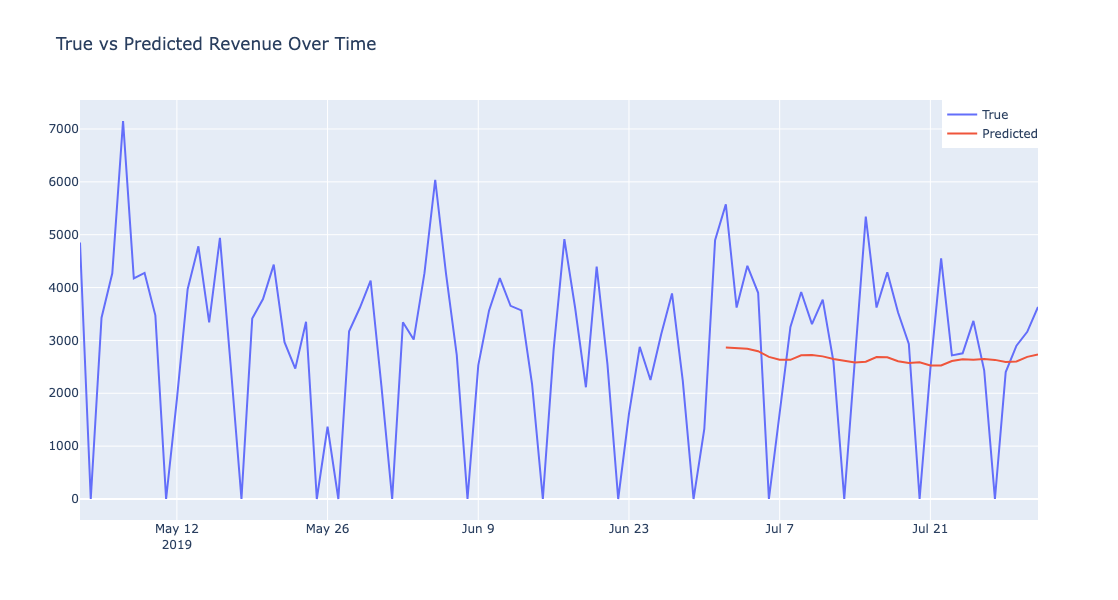

In [6]:
# Plot True vs Predicted Revenue of the baseline model
from plot_module import plot_predictions

plot_predictions(baseline_df[-90:].date.values, baseline_df[-90:].revenue.values, 
                 baseline_df[-30:].date.values, baseline_y_pred[-30:])

The baseline model, using a simple moving average, has performed as expected, very poorly, failing to capture the complexities and trends within the data.

## III - SARIMAX model

Given that the Augmented Dickey-Fuller (ADF) test indicates the time series is stationary, we will explore using a SARIMAX model for forecasting. 

However, it's important to note that the ADF test may not be robust, raising concerns about the appropriateness of this modeling approach for our data.

In [7]:
# start timer for runtime
sarimax_time_start = time.time()


# Prepare the data
auto_sarimax_df = ts_df.copy(deep=True)
auto_sarimax_df.set_index('date', inplace=True)
auto_sarimax_df=auto_sarimax_df.revenue

# Split data into train and test sets
auto_sarimax_df_train = auto_sarimax_df[:-30]
auto_sarimax_df_test  = auto_sarimax_df[-30:]

# Fit the auto_arima model
auto_sarimax_model = auto_arima(auto_sarimax_df_train,
                                 start_p=0, start_q=0, max_p=4, max_q=4,
                                 start_P=0, start_Q=0, max_P=4, max_Q=4,
                                 d=1, D=1, m=7, seasonal=True,
                                 error_action='ignore', trace=False,
                                 suppress_warnings=True, stepwise=False)

# Extract the Best Parameters
best_order = auto_sarimax_model.order
best_seasonal_order = auto_sarimax_model.seasonal_order

# Fit the SARIMAX model with the best parameters (Best auto_sarimax_model :  ARIMA(0,1,4)(0,1,1)[7])   
sarimax_model = SARIMAX(auto_sarimax_df_train,
                        order=best_order,
                        seasonal_order=best_seasonal_order).fit(disp=False)

# Generate forecasts
forecast = sarimax_model.get_forecast(steps=30)
forecast_index = auto_sarimax_df_test.index
predicted_values = forecast.predicted_mean

# Create a DataFrame for the predicted values
#predictions_df = pd.DataFrame(predicted_values, index=forecast_index, columns=['Predicted'])


# Calculate Root Mean Squared Error
sarimax_mse = mean_squared_error(auto_sarimax_df_test, predicted_values)
sarimax_rmse = sarimax_mse ** 0.5

# Print the RMSE 
print(f"\nThe Root Mean Squared Error of the sarimax model is {sarimax_rmse:,.0f}\n")

# Calculate runtime duration
sarimax_runtime = time.time() - sarimax_time_start
print('sarimax runtime : ', round(sarimax_runtime,0), 'seconds.\n')


The Root Mean Squared Error of the sarimax model is 679

sarimax runtime 215.15730381011963 seconds.



Let's plot the forecasted revenue against the actual revenue to assess the model's performance visually. 

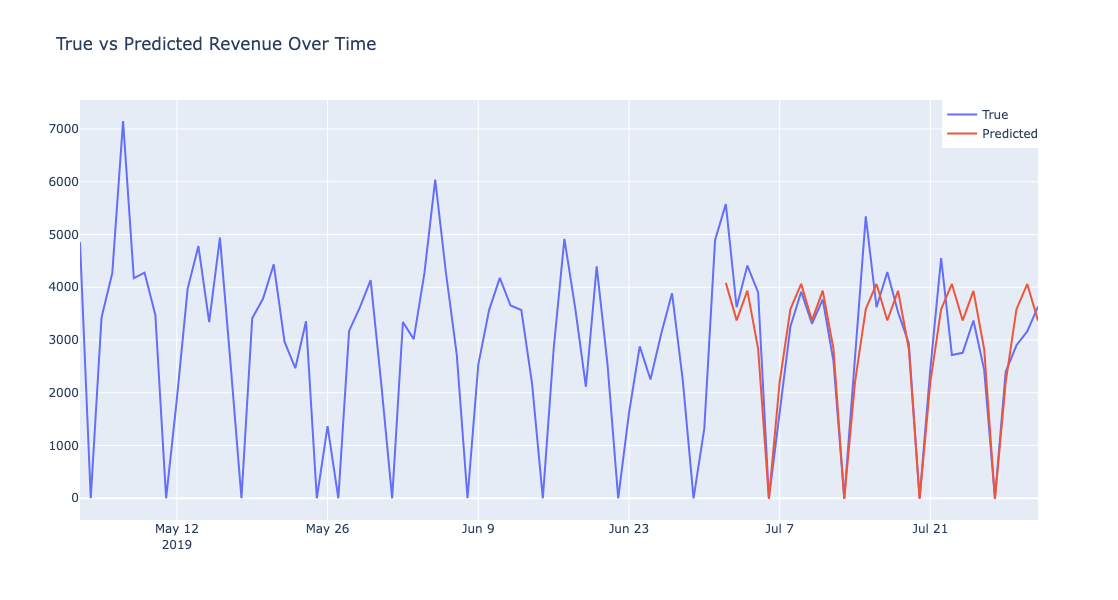

In [8]:
# Plot True vs Predicted revenue of the sarimax model 
from plot_module import plot_predictions

plot_predictions(auto_sarimax_df[-90:].index , auto_sarimax_df[-90:], 
                 auto_sarimax_df[-30:].index.values , predicted_values)

The results from the SARIMAX model are promising; however, its dependence on assumptions of linearity and stationarity may not be applicable to all datasets, potentially resulting in inaccuracies in production predictions.

Furthermore, the model often necessitates additional preprocessing to adequately handle multiple seasonalities (In this implementation, we did not incorporate the yearly seasonality) which can complicate implementation and adversely affect accuracy.

These limitations emphasize the necessity for more robust forecasting methodologies.

## IV - Prophet model

Let's explore a FB Prophet model.
This model is designed to handle various seasonal effects and missing data, making it a suitable candidate for our forecasting needs.

In [17]:
# start timer for runtime
prophet_time_start = time.time()


# Prepare the data
prophet_df = ts_df.copy(deep=True)

prophet_df.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)## Create a copy of the dataframe to avoid modifying the original data
prophet_df_scaled = prophet_df.copy(deep=True)

## Scale the exogenous variables
prophet_scaler = StandardScaler()
prophet_df_scaled[['purchases', 'total_views']] = prophet_scaler.fit_transform(prophet_df_scaled[['purchases', 'total_views']])


## Define the cut-off date to exclude the last month
# Get the maximum date
last_date = prophet_df_scaled['ds'].max()  
# Calculate the date one month before the max date
initial_date = last_date - pd.DateOffset(days=30)  

# Filter the data up to the initial date for training
prophet_df_scaled_train = prophet_df_scaled[prophet_df_scaled['ds'] < initial_date]
prophet_df_scaled_test = prophet_df_scaled[prophet_df_scaled['ds'] >= initial_date]  # Test data for the last 30 days

# Initialize the Prophet model with seasonality
prophet_model = Prophet(weekly_seasonality=True,   
                        yearly_seasonality=True)

# Add external regressors
prophet_model.add_regressor('purchases')
prophet_model.add_regressor('total_views')

# Fit the model to the training data
prophet_model.fit(prophet_df_scaled_train);

# Make predictions for the last 30 days using actual data
prophet_df_scaled_test = prophet_df_scaled[prophet_df_scaled['ds'] >= initial_date].copy()  # Filter last 30 days for predictions
prophet_forecast = prophet_model.predict(prophet_df_scaled_test)

# Calculate Root Mean Squared Error
prophet_mse = mean_squared_error(prophet_df_scaled_test['y'], prophet_forecast['yhat'])
prophet_rmse = prophet_mse ** 0.5

# Print the RMSE 
print(f"\nThe Root Mean Squared Error of the prophet model is {prophet_rmse:,.0f}\n")


# Calculate runtime duration
prophet_runtime = time.time() - prophet_time_start
print('prophet runtime : ', round(prophet_runtime,0), 'seconds.\n')

17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing



The Root Mean Squared Error of the prophet model is 359

prophet runtime 1.0 seconds.



Let's plot the forecasted revenue against the actual revenue to assess the model's performance visually. 

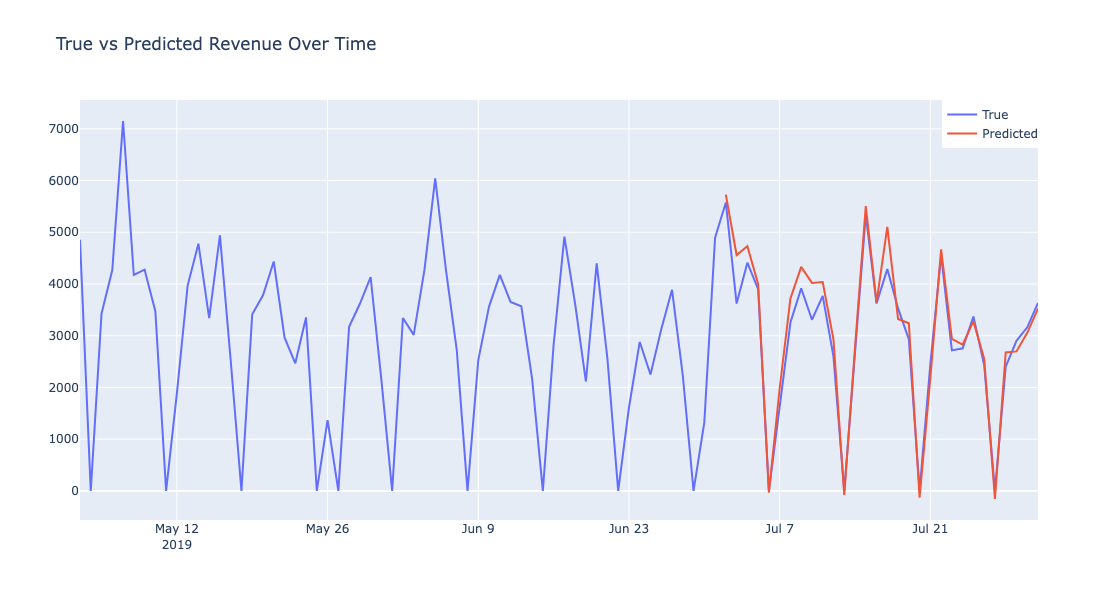

In [10]:
# Plot True vs Predicted revenue of the prophet model 
from plot_module import plot_predictions

plot_predictions(prophet_df_scaled[-90:].ds.values , prophet_df_scaled[-90:].y.values, 
                 prophet_df_scaled[-30:].ds.values , prophet_forecast[-30:].yhat.values)

After fitting the prophet model, the results have proven to be quite promising. 

Prophet's capacity to capture multiple seasonal effects has greatly enhanced forecasting accuracy.

With its automatic trend detection and minimal preprocessing needs, the implementation process is straightforward, and its robustness to outliers further reinforces its reliability.

## V - Random Forest Regression model

Finally, we will explore a Random Forest Regression model for forecasting the revenue. 

This ensemble learning method is known for its ability to capture complex relationships in the data without relying on the linearity assumptions of traditional models making it a suitable candidate for our forecasting needs.

In [16]:
# start timer for runtime
random_forest_regressor_time_start = time.time()


# Prepare the data
random_forest_regressor_df = ts_df.copy(deep=True)

# Feature Engineering
random_forest_regressor_df['year'] = random_forest_regressor_df['date'].dt.year
random_forest_regressor_df['month'] = random_forest_regressor_df['date'].dt.month
random_forest_regressor_df['day'] = random_forest_regressor_df['date'].dt.day
random_forest_regressor_df['day_of_week'] = random_forest_regressor_df['date'].dt.dayofweek  
random_forest_regressor_df['week_of_year'] = random_forest_regressor_df['date'].dt.isocalendar().week

# Creating lag features
random_forest_regressor_df['7_lag_revenue'] = random_forest_regressor_df['revenue'].shift(7)
random_forest_regressor_df.dropna(inplace=True)  # Drop rows with NaN values

# Define Features and Target Variable
random_forest_regressor_X = random_forest_regressor_df[['year', 'month', 'day', 'day_of_week', 'week_of_year', 'purchases', 'total_views', '7_lag_revenue']]
random_forest_regressor_y = random_forest_regressor_df['revenue']

# Split data into train and test sets 
random_forest_regressor_X_train = random_forest_regressor_X[:-30] 
random_forest_regressor_X_test = random_forest_regressor_X[-30:]  
random_forest_regressor_y_train = random_forest_regressor_y[:-30] 
random_forest_regressor_y_test = random_forest_regressor_y[-30:]  

# Create a pipeline with scaling and the random forest model
random_forest_regressor_pipeline = Pipeline([
    ('random_forest_regressor_scaler', StandardScaler()),
    ('random_forest_regressor_model', RandomForestRegressor(random_state=42)) 
                                            ])

# Hyperparameter tuning for n_estimators
random_forest_regressor_param_grid = {'random_forest_regressor_model__n_estimators': [75, 100, 150] ,
                                      'random_forest_regressor_model__criterion': ['squared_error']}
                                     

random_forest_regressor_grid_search = GridSearchCV(random_forest_regressor_pipeline, 
                                         random_forest_regressor_param_grid, 
                                         cv=5, n_jobs=-1)

random_forest_regressor_grid_search.fit(random_forest_regressor_X_train, random_forest_regressor_y_train)

# Best model
random_forest_regressor_best_model = random_forest_regressor_grid_search.best_estimator_

# Make Predictions
random_forest_regressor_y_pred = random_forest_regressor_best_model.predict(random_forest_regressor_X_test)

# Evaluate the Model
random_forest_regressor_mse = mean_squared_error(random_forest_regressor_y_test, random_forest_regressor_y_pred)
random_forest_regressor_rmse = random_forest_regressor_mse ** 0.5

# Print the RMSE 
print(f"\nThe Root Mean Squared Error of the random forest regression model is {random_forest_regressor_rmse:,.0f}\n")


# Calculate runtime duration
random_forest_regressor_runtime = time.time() - random_forest_regressor_time_start
print('random forest regression runtime : ', round(random_forest_regressor_runtime,0), 'seconds.\n')


The Root Mean Squared Error of the random forest regression model is 325

random forest regression runtime 12.0 seconds.



Let's plot the forcasted vs the True revenue

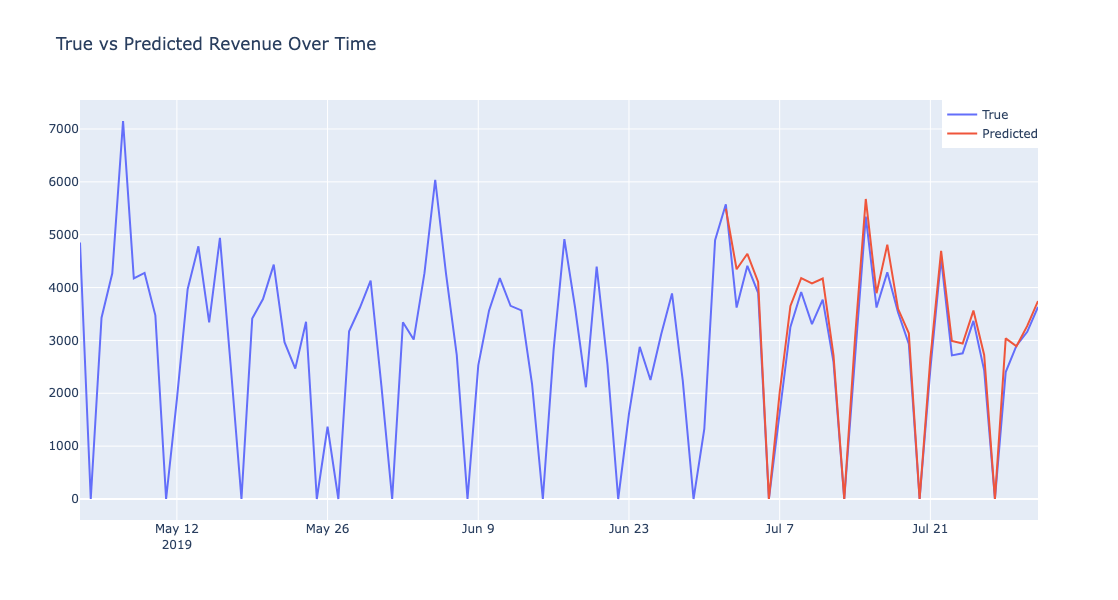

In [12]:
# Plot True vs Predicted revenue of the random forest regressor model 
from plot_module import plot_predictions

plot_predictions(random_forest_regressor_df.date[-90:] , random_forest_regressor_df.revenue[-90:], 
                 random_forest_regressor_df.date[-30:] , random_forest_regressor_y_pred)

The Random Forest Regression model has emerged as an effective forecasting approach.

Its ability to capture complex patterns in the data and deliver accurate predictions without stringent assumptions of linearity or stationarity, heteroskedasticity or normality sets it apart from previous models.

## VI - Comparison   

We finish by comparing all the outputed RMSEs alongside their respective runtimes for each model.

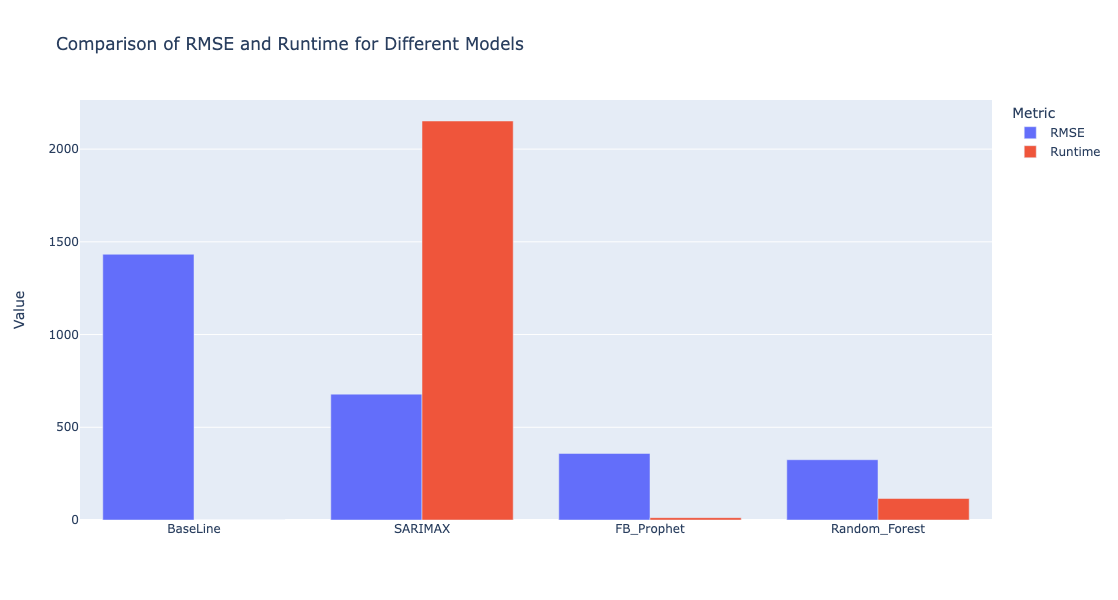

In [13]:
# Plot the comparison of RMSE and Runtime for Different Models
from plot_module import plot_models_comparison

models = ['BaseLine', 'SARIMAX', 'FB_Prophet', 'Random_Forest']
rmse_values = [baseline_rmse, sarimax_rmse, prophet_rmse, random_forest_regressor_rmse]
runtime_values = [baseline_runtime, sarimax_runtime, prophet_runtime, random_forest_regressor_runtime]

plot_models_comparison(models, rmse_values, runtime_values)

Based on the models evaluated, the Random Forest Regression model demonstrates the best performance when considering runtime, making it the most suitable choice for deployment. Its efficiency not only ensures timely predictions but also enhances overall operational performance, allowing for more agile decision-making. 

# D - Next steps   

As the next steps, we will prepare the deployment pipeline for a Prophet's model to transition seamlessly from development to production. 

Our deployment process will begin with building a draft API, incorporating endpoints for training, prediction, and log retrieval to ensure model retraining and usage monitoring. We'll containerize the API, model, and unit tests with Docker to enhance reproducibility and facilitate easy scaling across different environments. 

Applying test-driven development, we will iteratively refine the API to anticipate scale, load, and potential data drift over time, ensuring a robust model lifecycle.